In [58]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from dotenv import load_dotenv, find_dotenv
import mlflow

In [4]:
load_dotenv(find_dotenv())

os.environ["AWS_ACCESS_KEY_ID"] = os.environ.get("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.environ.get("AWS_SECRET_ACCESS_KEY")
os.environ["S3_BUCKET_NAME"] = os.environ.get("S3_BUCKET_NAME")
os.environ["S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"

RANDOM_STATE = 42

In [5]:
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000
EXPERIMENT_NAME = "sprint5"

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

os.environ["MLFLOW_HTTP_REQUEST_TIMEOUT"] = "10"

# Часть 1

## Этап 1

In [6]:
uplift_fp_data = pd.read_csv('uplift_fp_data.csv') 
uplift_fp_data.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,target
0,10,1,142.44,1,0,1,0,1,1,0
1,6,2,329.08,1,1,2,1,2,0,0
2,7,1,180.65,0,1,1,1,2,1,0
3,9,4,675.83,1,0,2,1,2,0,0
4,2,0,45.34,1,0,0,0,2,1,0


Категоиральных колонок нет, а значит перекодирвать не нужно

In [6]:
uplift_fp_data.isnull().sum()


recency            0
history_segment    0
history            0
mens               0
womens             0
zip_code           0
newbie             0
channel            0
treatment          0
target             0
dtype: int64

Пропусков нет и это великлепно

## Этап 2

### EDA


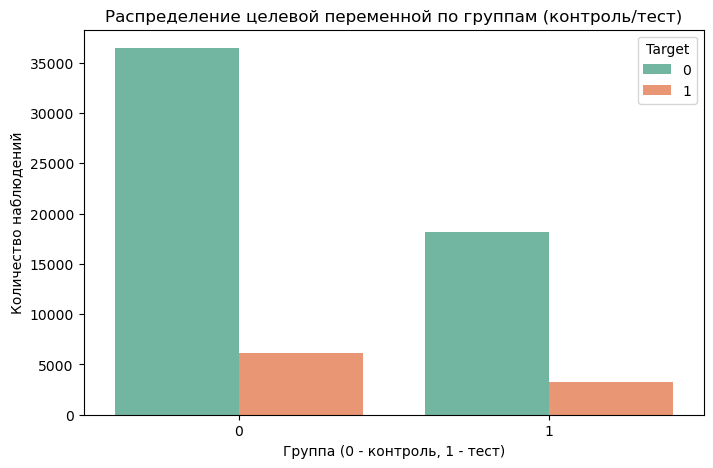

Распределение по treatment и target:


target,0,1
treatment,,
0,36457,6156
1,18149,3238



Доли целевого события в каждой группе:


target,0,1
treatment,,
0,0.856,0.144
1,0.849,0.151


In [7]:
# Проверим распределение целевой переменной между контрольной и тестовой группами
grouped = uplift_fp_data.groupby(['treatment', 'target']).size().reset_index(name='count')

# Построим barplot
plt.figure(figsize=(8, 5))
sns.barplot(
    data=grouped,
    x='treatment',
    y='count',
    hue='target',
    palette='Set2'
)
plt.title('Распределение целевой переменной по группам (контроль/тест)')
plt.xlabel('Группа (0 - контроль, 1 - тест)')
plt.ylabel('Количество наблюдений')
plt.legend(title='Target')
plt.show()

# Также выведем абсолютные и относительные значения для контроля
print("Распределение по treatment и target:")
display(
    uplift_fp_data.groupby(['treatment', 'target']).size().unstack(fill_value=0)
)
print("\nДоли целевого события в каждой группе:")
display(
    uplift_fp_data.groupby('treatment')['target'].value_counts(normalize=True).unstack().round(3)
)


Проверим баланс классов

In [16]:
uplift_fp_data['target'].value_counts(normalize=True)

target
0    0.853219
1    0.146781
Name: proportion, dtype: float64

In [15]:
uplift_fp_data['treatment'].value_counts(normalize=True)

treatment
0    0.665828
1    0.334172
Name: proportion, dtype: float64

### **Вывод по EDA:**

- **Распределение целевой переменной (`target`) между контрольной (`treatment=0`) и тестовой (`treatment=1`) группами очень схожи.**
- **Доля целевого события составляет примерно 14–15% в обеих группах.**
- Это говорит о корректной рандомизации и отсутствии явных перекосов между группами.
- Абсолютное количество наблюдений в контрольной группе примерно в два раза больше, чем в тестовой. Это важно учитывать при дальнейшем анализе.


# Этап 2

### Проверка на статистическую значимость

Шаг 1: Разделите данные на контрольную и тестовую группы

In [7]:
control = uplift_fp_data[uplift_fp_data['treatment'] == 0]['target']
treatment = uplift_fp_data[uplift_fp_data['treatment'] == 1]['target']

Шаг 2: Анализ средних значений и стандартных отклонений

In [8]:
mean_control = np.mean(control)
std_control = np.std(control, ddof=1)

mean_treatment = np.mean(treatment)
std_treatment = np.std(treatment, ddof=1)

# Вывод
print("📊 Статистики по группам:\n")
print(f"Контрольная группа:")
print(f"  Среднее значение:           {mean_control:.4f}")
print(f"  Стандартное отклонение:     {std_control:.4f}\n")

print(f"Тестовая группа:")
print(f"  Среднее значение:           {mean_treatment:.4f}")
print(f"  Стандартное отклонение:     {std_treatment:.4f}")

📊 Статистики по группам:

Контрольная группа:
  Среднее значение:           0.1445
  Стандартное отклонение:     0.3516

Тестовая группа:
  Среднее значение:           0.1514
  Стандартное отклонение:     0.3584


#### Вывод по результатам сравнения групп

- **Среднее значение** в тестовой группе (0.1514) чуть выше, чем в контрольной (0.1445).  
- **Стандартное отклонение** также немного выше в тестовой группе (0.3584 против 0.3516), что говорит о немного большей разбросанности данных.  
- Разница в средних значениях **незначительная** — предварительно можно предположить, что эффекта почти нет, однако для окончательного вывода стоит провести статистический тест (например, t-тест для независимых выборок), чтобы проверить, является ли эта разница статистически значимой.

**Предварительный вывод:** изменений между контрольной и тестовой группой практически не наблюдается.

##### 📄 Шаг 3: Обоснование выбора статистического теста

Целевая переменная `target` является бинарной (0 или 1), поэтому сравнение между контрольной и тестовой группами фактически означает сравнение **долей откликнувшихся пользователей**.

##### Возможные тесты:
- **t-тест для независимых выборок (Welch’s t-test)** — сравнивает средние (в нашем случае — доли), допускает разные дисперсии.
- **Манна–Уитни (непараметрический тест)** — сравнивает распределения, используется если данные не нормальны.
- **Z-тест для пропорций** — также подходит, но t-тест используется чаще, так как он встроен в большинство библиотек и адаптирован под реальную дисперсию.

##### Наш подход:
1. Проверяем нормальность распределений в каждой группе с помощью **теста Шапиро–Уилка**.
2. Если обе группы нормальны (p > 0.05), используем **t-тест с поправкой на неравные дисперсии (Welch’s)**.
3. Если хотя бы одно распределение не нормальное — используем **тест Манна–Уитни**.

Таким образом, тест выбирается адаптивно и надёжно.

Шаг 4: Применяем выбранный статистический тест

In [9]:
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

# Проверка нормальности
p_shapiro_control = shapiro(control).pvalue
p_shapiro_treatment = shapiro(treatment).pvalue

print("\n📈 Проверка нормальности (тест Шапиро–Уилка):")
print(f"  Контрольная группа: p = {p_shapiro_control:.4f}")
print(f"  Тестовая группа:    p = {p_shapiro_treatment:.4f}")

# Выбор и применение теста
if p_shapiro_control > 0.05 and p_shapiro_treatment > 0.05:
    test_name = "t-тест (Welch’s)"
    stat, p_value = ttest_ind(treatment, control, equal_var=False)
else:
    test_name = "тест Манна–Уитни"
    stat, p_value = mannwhitneyu(treatment, control, alternative='two-sided')

# Вывод результата
print(f"\n🧪 Применённый тест: {test_name}")
print(f"  Статистика: {stat:.4f}")
print(f"  p-value:    {p_value:.4f}")


📈 Проверка нормальности (тест Шапиро–Уилка):
  Контрольная группа: p = 0.0000
  Тестовая группа:    p = 0.0000

🧪 Применённый тест: тест Манна–Уитни
  Статистика: 458843376.5000
  p-value:    0.0193


/Users/a.hrameev/miniconda3/envs/ya/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 42613.
  res = hypotest_fun_out(*samples, **kwds)
/Users/a.hrameev/miniconda3/envs/ya/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21387.
  res = hypotest_fun_out(*samples, **kwds)


Шаг 5: Интерпретация результата

In [10]:
if p_value < 0.05:
    print("\n✅ Различия между группами статистически значимы (p < 0.05).")
else:
    print("\n❌ Различия между группами не являются статистически значимыми (p ≥ 0.05).")


✅ Различия между группами статистически значимы (p < 0.05).


#### **Вывод:**  
Хотя среднее значение в тестовой группе лишь немного выше, чем в контрольной, а разброс данных схож, статистический анализ показал, что эта разница является статистически значимой (p < 0.05), что указывает на наличие реального эффекта, а не случайного колебания.


## Построение корреляций

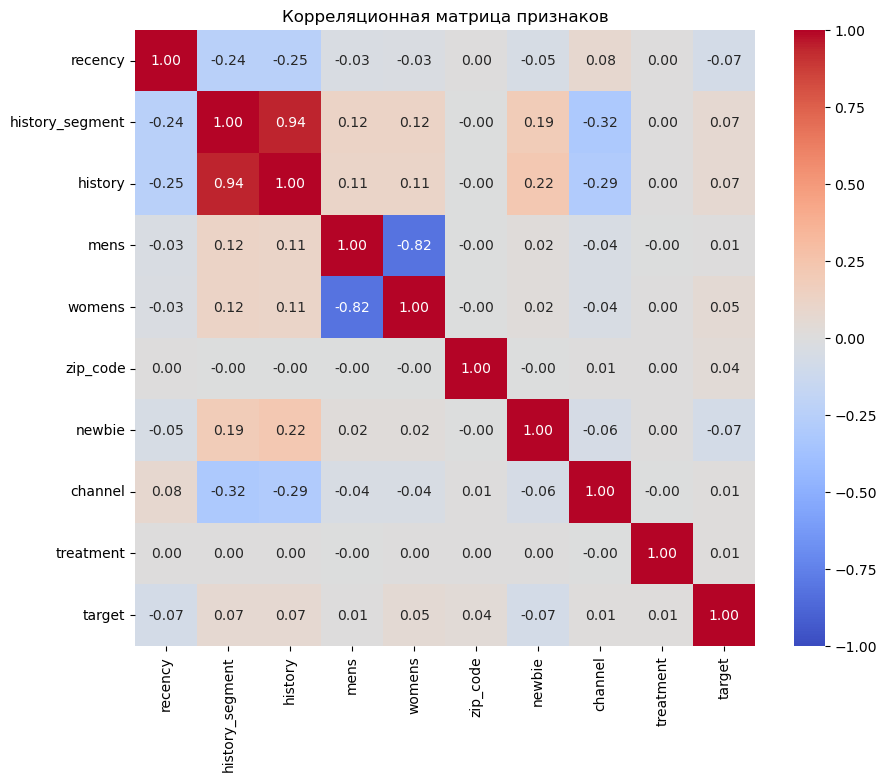

Корреляция признаков с целевой переменной (target):
history_segment    0.069734
history            0.065153
womens             0.051999
zip_code           0.037570
channel            0.010584
treatment          0.009247
mens               0.006712
newbie            -0.073924
recency           -0.074765
Name: target, dtype: float64

Корреляция признаков с переменной treatment:
target             0.009247
history_segment    0.001869
newbie             0.001416
history            0.001247
recency            0.000831
womens             0.000544
zip_code           0.000214
channel           -0.002954
mens              -0.002991
Name: treatment, dtype: float64


In [12]:
# Рассчитаем корреляционную матрицу по всем числовым признакам, включая target и treatment
corr_matrix = uplift_fp_data.corr(numeric_only=True)

# Визуализируем корреляционную матрицу с помощью тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Корреляционная матрица признаков")
plt.show()

# Посмотрим на корреляцию признаков с целевой переменной, исключая саму переменную
corr_with_target = corr_matrix['target'].drop('target').sort_values(ascending=False)
print("Корреляция признаков с целевой переменной (target):")
print(corr_with_target)

# Посмотрим на корреляцию признаков с treatment, исключая саму переменную
corr_with_treatment = corr_matrix['treatment'].drop('treatment').sort_values(ascending=False)
print("\nКорреляция признаков с переменной treatment:")
print(corr_with_treatment)


#### **Вывод по корреляционному анализу:**

- Анализ корреляции показал, что связь признаков с целевой переменной **слабая** (коэффициенты не превышают ±0.08), что указывает на отсутствие выраженной линейной зависимости. Наибольшую положительную корреляцию с целевой переменной имеют `history_segment` (0.0697) и `history` (0.0652), а наибольшую отрицательную — `recency` (-0.0748) и `newbie` (-0.0739).  

- Связь признаков с переменной `treatment` практически отсутствует (значения коэффициентов близки к нулю), что говорит об отсутствии мультиколлинеарности между фактором назначения в тест и другими признаками.  

- **Для стратификации** при формировании тестовой и контрольной групп можно использовать признаки, наиболее связанные с целевой переменной: `history_segment`, `history`, `recency`, `newbie`. Это позволит сбалансировать группы по значимым характеристикам.  

- **Признаки с минимальной информативностью** по отношению к целевой переменной и `treatment` (`channel`, `mens`, `zip_code`) можно рассматривать как кандидатов для исключения из модели или анализа, так как их вклад в прогноз и сегментацию минимален.

## Этап 3

#### **Обоснование выбора uplift-модели**
В качестве бейзлайна для uplift-моделирования используется просто CatBoostClassifier.
 
CatBoost хорошо работает с категориальными и числовыми признаками, устойчив к мультиколлинеарности и не требует сложной предобработки данных. 
Для задачи с бинарным treatment и целевой переменной CatBoostClassifier позволяет быстро получить сильную базовую модель для оценки uplift-эффекта.

### Разбиение выборки на тренировочную и тестовую

In [93]:
from sklearn.model_selection import train_test_split

# Разделим данные на признаки и целевую переменную
X = uplift_fp_data.drop('target', axis=1)
y = uplift_fp_data['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=uplift_fp_data[['target', 'treatment']]
)



### Обучение выбранного бейзлайна

In [33]:
from catboost import CatBoostClassifier

# CatBoostClassifier для бейзлайна
catboost_model = CatBoostClassifier(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    random_seed=42,
    verbose=100,
    allow_writing_files=False
)

# Обучаем CatBoost на тренировочных данных
catboost_model.fit(X_train, y_train)


0:	learn: 0.6451566	total: 58.9ms	remaining: 5.83s
99:	learn: 0.3975504	total: 231ms	remaining: 0us


In [34]:
# чтобы оценить uplift-эффекта для каждого пользователя:
# 1. Создаём копию тестовых данных
X_test_uplift = X_test.copy()
X_test_treated = X_test.copy()
X_test_control = X_test.copy()

# 2. Устанавливаем значение признака treatment
X_test_treated['treatment'] = 1  # С воздействием
X_test_control['treatment'] = 0  # Без воздействия

# 3. Предсказываем результаты для обоих случаев
y_pred_treated = catboost_model.predict_proba(X_test_treated)[:,1]
y_pred_control = catboost_model.predict_proba(X_test_control)[:,1]

# 4. Вычисляем uplift как разницу между предсказаниями
uplift_vals = y_pred_treated - y_pred_control

# Добавляем предсказанный uplift к тестовым данным для анализа
X_test_uplift['predicted_uplift'] = uplift_vals

X_test_uplift

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,predicted_uplift
8020,2,0,36.89,1,0,1,0,1,0,-0.015254
63345,11,1,156.72,1,0,1,0,2,1,-0.027180
7493,5,0,38.93,0,1,1,1,1,0,0.034023
4673,1,4,558.84,1,0,0,1,0,0,-0.019766
7910,3,1,167.13,0,1,1,0,1,0,0.047216
...,...,...,...,...,...,...,...,...,...,...
14552,9,1,102.42,1,0,1,1,1,0,-0.002421
50779,3,2,323.02,1,0,1,0,1,0,-0.029605
40568,2,3,389.30,0,1,0,0,1,0,0.035755
46954,7,1,106.54,0,1,1,0,2,1,0.041937


### Важность признаков представить в виде графика

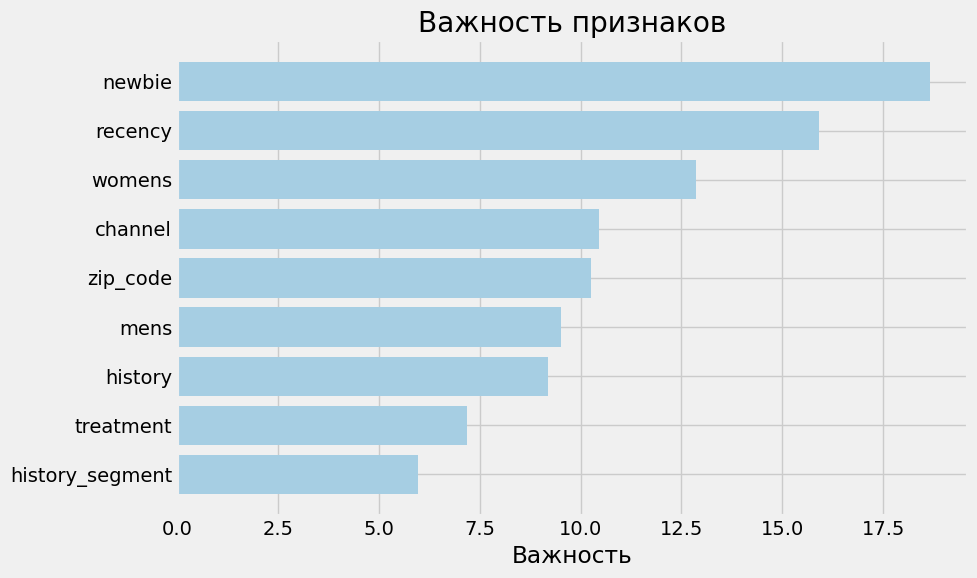

Важности признаков:
newbie: 18.6697
recency: 15.9126
womens: 12.8539
channel: 10.4479
zip_code: 10.2540
mens: 9.5058
history: 9.2048
treatment: 7.1851
history_segment: 5.9661


In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Получим важности признаков из модели CatBoost
feature_importances = catboost_model.get_feature_importance()
feature_names = X_train.columns

# Отсортируем признаки по важности
indices = np.argsort(feature_importances)[::-1]
sorted_features = feature_names[indices]
sorted_importances = feature_importances[indices]

plt.figure(figsize=(10, 6))
plt.title("Важность признаков")
plt.barh(range(len(sorted_features)), sorted_importances[::-1], align='center')
plt.yticks(range(len(sorted_features)), sorted_features[::-1])
plt.xlabel("Важность")
plt.tight_layout()
plt.savefig("feature_importance.png", format="png")  # Сохраняем как PNG
plt.show()

# Выведем важности признаков списком
print("Важности признаков:")
for name, importance in zip(sorted_features, sorted_importances):
    print(f"{name}: {importance:.4f}")


На графике выше видно, что наибольшую важность для модели имеют следующие признаки (значения важности указаны в скобках):
 - newbie (новый клиент): 18.67
 - recency (давность последней покупки): 15.91
 - womens (пол — женский): 12.85
 - channel (канал коммуникации): 10.45
 - zip_code (почтовый индекс): 10.25
 - mens (пол — мужской): 9.51
 - history (история покупок): 9.20
 - treatment (факт воздействия): 7.19
 - history_segment (сегмент по истории): 5.97

 Наибольший вклад в предсказания модели вносит признак "newbie" (новый клиент), а также признаки, связанные с давностью последней покупки (recency) и полом клиента (womens, mens).
 Признаки "channel", "zip_code", "history" и "treatment" также оказывают заметное влияние на предсказания модели.
 Сегмент по истории ("history_segment") имеет наименьшую, но не нулевую важность.

 Это говорит о том, что статус клиента (новый или нет), его недавняя активность, а также пол и канал коммуникации — ключевые факторы для uplift-моделирования в данной задаче.
Для дальнейшего улучшения модели стоит сфокусироваться на анализе поведения новых клиентов, а также на генерации новых признаков, связанных с каналом коммуникации и историей покупок.


### Расчет метрик для выбранного бейзлайна на тестовой выборке

In [75]:
from sklift.metrics import uplift_at_k, qini_auc_score, uplift_auc_score

# Qini AUC
qini_auc = qini_auc_score(y_true=y_test.values, uplift=uplift_vals, treatment=X_test_uplift['treatment'].values)

# Uplift AUC
uplift_auc = uplift_auc_score(y_true=y_test.values, uplift=uplift_vals, treatment=X_test_uplift['treatment'].values)

# Uplift@30%
uplift_at_30 = uplift_at_k(y_true=y_test.values, uplift=uplift_vals, treatment=X_test_uplift['treatment'].values, strategy='by_group', k=0.3)

print(f"Qini AUC: {qini_auc:.4f}")
print(f"Uplift AUC: {uplift_auc:.4f}")
print(f"Uplift@30%: {uplift_at_30:.4f}")


Qini AUC: 0.0574
Uplift AUC: 0.0256
Uplift@30%: 0.0362


#### 📊 Выводы по метрикам

| Метрика        | Значение  |
|:--------------:|:---------:|
| **Qini AUC**   | 0.0574    |
| **Uplift AUC** | 0.0256    |
| **Uplift@30%** | 0.0362    |

Значения метрик невысокие.

Модель неплохо различает пользователей, на которых воздействие `treatment` оказывает положительный эффект, однако потенциал для улучшения остается значительным.

**Рекомендации:**
- Продолжить работу над feature engineering
- Рассмотреть альтернативные модели (`Т-Learner`, `X-Learner` и др.)

#### Логируем в mlflow

In [47]:
import mlflow.catboost
from mlflow.models.signature import infer_signature

RUN_NAME_CATBOOST = "uplift_baseline_catboost"
REGISTRY_MODEL_NAME = "uplift_baseline_catboost"

mlflow.set_experiment(EXPERIMENT_NAME)


with mlflow.start_run(run_name=RUN_NAME_CATBOOST):
    # Логируем параметры модели
    mlflow.log_params(catboost_model.get_params())

    # Логируем uplift-метрики
    mlflow.log_metric("qini_auc", qini_auc)
    mlflow.log_metric("uplift_auc", uplift_auc)
    mlflow.log_metric("uplift_at_30", uplift_at_30)

    # Логируем важность признаков как артефакт
    mlflow.log_artifact("feature_importance.png")

    # сигнатура для модели
    signature = infer_signature(X_test, catboost_model.predict(X_test))

    # Логируем модель в MLflow
    mlflow.catboost.log_model(
        cb_model=catboost_model,
        name="uplift_model",
        registered_model_name=REGISTRY_MODEL_NAME, 
        pip_requirements="./requirements.txt",
        signature=signature
    )

2025/08/07 15:53:53 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/md/wzk6m8kj39v1mnc59nyt9z5m0000gn/T/tmp4yxr5uwu/model, flavor: catboost). Fall back to return ['catboost==1.2.8']. Set logging level to DEBUG to see the full traceback. 
Successfully registered model 'uplift_baseline_catboost'.
2025/08/07 15:53:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: uplift_baseline_catboost, version 1
Created version '1' of model 'uplift_baseline_catboost'.


🏃 View run uplift_baseline_catboost at: http://127.0.0.1:5000/#/experiments/34/runs/13460957fab343d4bccf9431bb64f7a6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/34


# Обучение 2 моделей 

Некоторые uplift модели из библиотеки `causalml` будут требовать категориальные значения воздействия. Для этого используйте маппинг

In [105]:
from sklearn.model_selection import train_test_split

# Разделим данные на признаки и целевую переменную
X = uplift_fp_data.drop('target', axis=1)
y = uplift_fp_data['target']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=uplift_fp_data[['target', 'treatment']] 
)

### Обучение модели 1

In [91]:
from causalml.inference.meta import BaseTClassifier
from sklearn.ensemble import RandomForestClassifier
from sklift.metrics import uplift_auc_score, qini_auc_score

# создаём базовые модели для тестовой и контрольной групп 
treatment_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    random_state=RANDOM_STATE,
    class_weight='balanced',
)

control_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    random_state=RANDOM_STATE,
    class_weight='balanced',
)

# инициализируем T-learner
t_learner = BaseTClassifier(
    treatment_learner=treatment_model,
    control_learner=control_model,
    control_name=0,  # название контрольной группы в столбце treatment
)

# обучаем T-learner
t_learner.fit(
    X=X_train.values,  # Признаки без столбца treatment
    treatment=X_train['treatment'].values,       # Столбец с признаком воздействия
    y=y_train.values                            # Целевая переменная
)

In [26]:
uplift_pred = t_learner.predict(X_test.values)

### Получение метрик по модели 1

In [92]:
from sklift.metrics import uplift_at_k, qini_auc_score, uplift_auc_score

# Qini AUC
qini_auc = qini_auc_score(y_true=y_test.values, uplift=uplift_pred.squeeze(), treatment=X_test['treatment'].values)

# Uplift AUC
uplift_auc = uplift_auc_score(y_true=y_test.values, uplift=uplift_pred.squeeze(), treatment=X_test['treatment'].values)

# Uplift@30%
uplift_at_30 = uplift_at_k(y_true=y_test.values, uplift=uplift_pred.squeeze(), treatment=X_test['treatment'].values, strategy='by_group', k=0.3)

print(f"Qini AUC: {qini_auc:.4f}")
print(f"Uplift AUC: {uplift_auc:.4f}")
print(f"Uplift@30%: {uplift_at_30:.4f}")

Qini AUC: 0.0607
Uplift AUC: 0.0269
Uplift@30%: 0.0328


#### 📊 Метрики T-Learner

| Метрика        | Значение |
|:--------------:|:--------:|
| **Qini AUC**   | 0.0607   |
| **Uplift AUC** | 0.0269   |
| **Uplift@30%** | 0.0328   |

Качество модели низкое — способность выявлять пользователей с положительным эффектом воздействия близка к случайной.

#### 📌 Рекомендации
- Улучшить признаки (**feature engineering**).
- Проверить фичи отдельно в treatment и control.
- Протестировать другие методы: `UpliftRandomForestClassifier`, X-Learner, R-Learner.

### Обучение модели 2

In [125]:
from sklearn.model_selection import train_test_split

# Разделим данные на признаки и целевую переменную
X = uplift_fp_data.drop('target', axis=1)
y = uplift_fp_data['target']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=uplift_fp_data[['target', 'treatment']] 
)

In [127]:
import numpy as np
import pandas as pd
from causalml.inference.meta import BaseRClassifier
from xgboost import XGBClassifier, XGBRegressor

features = uplift_fp_data.drop(columns=['target','treatment']).columns
T = X_train.treatment.values  # 1 - treatment, 0 - control
X_train = X_train[features]
y_train = y_train.values  # целевая переменная
T_test = X_test.treatment.values


# инициализируем R-learner с моделями XGBoost
# outcome_learner — модель для предсказания исхода без учёта воздействия
# effect_learner — модель для оценки эффекта воздействия
# propensity_learner — модель для оценки вероятности получения воздействия
r_learner = BaseRClassifier(
    outcome_learner=XGBClassifier(
        n_estimators=200,
        learning_rate=0.02,
        max_depth=6,
        random_state=42,
        verbosity=0
    ),
    effect_learner=XGBRegressor(
        n_estimators=200,
        learning_rate=0.01,
        max_depth=6,
        random_state=42,
        verbosity=0
    ),
    propensity_learner=XGBClassifier(
        n_estimators=200,
        learning_rate=0.02,
        max_depth=6,
        random_state=42,
        verbosity=0
    )
)

# инициализируем массив для propensity score
e_x = np.zeros(len(X_train))
T_test = X_test.treatment.values

# обучаем модель для оценки propensity score
model_e = XGBClassifier(n_estimators=200, 
                        learning_rate=0.02, 
                        max_depth=6, 
                        random_state=42, 
                        verbosity=0)
model_e.fit(X_train, T)
e_x = model_e.predict_proba(X_train)[:, 1]

# обучаем модель R-learner
r_learner.fit(
    X=X_train,
    treatment=T,
    y=y_train,
    p=e_x,
    verbose=True
)


In [128]:
uplift_pred = r_learner.predict(X_test.drop(columns=['treatment']).values)

### Получение метрик по модели 2

In [129]:
from sklift.metrics import uplift_at_k, qini_auc_score, uplift_auc_score

# Qini AUC
qini_auc = qini_auc_score(y_true=y_test.values, uplift=uplift_pred.squeeze(), treatment=X_test['treatment'].values)

# Uplift AUC
uplift_auc = uplift_auc_score(y_true=y_test.values, uplift=uplift_pred.squeeze(), treatment=X_test['treatment'].values)

# Uplift@30%
uplift_at_30 = uplift_at_k(y_true=y_test.values, uplift=uplift_pred.squeeze(), treatment=X_test['treatment'].values, strategy='by_group', k=0.3)

print(f"Qini AUC: {qini_auc:.4f}")
print(f"Uplift AUC: {uplift_auc:.4f}")
print(f"Uplift@30%: {uplift_at_30:.4f}")

Qini AUC: 0.0581
Uplift AUC: 0.0259
Uplift@30%: 0.0302


#### 📊 Метрики X-Learner

| Метрика        | Значение |
|:--------------:|:--------:|
| **Qini AUC**   | 0.0581   |
| **Uplift AUC** | 0.0259   |
| **Uplift@30%** | 0.0302   |

Качество модели остаётся низким — способность X-Learner выявлять пользователей с положительным эффектом воздействия по-прежнему близка к случайному выбору.

#### 📌 Рекомендации
- Улучшить признаки (**feature engineering**).
- Проанализировать распределения и значимость фич отдельно в treatment и control.
- Рассмотреть альтернативные подходы: `UpliftRandomForestClassifier`, T-Learner, R-Learner.  
- Проверить корректность предобработки данных и балансировки групп.

Проинтерпретируйте полученные результаты и обоснуйте выбор 1 модели в этой ячейке

# Часть 2

## Этап 1
Улучшите бейзлайн выбранной модели

#### Генерация признаков (опционально)

### Подбор гиперпараметров

In [ ]:
from optuna import create_study
from sklift.metrics import uplift_at_k

def objective(trial):
    # Дополните код для подбора гиперпараметров

    uplift_at_30 = uplift_at_k(y_test, uplift_pred, treatment_test, k=0.3, strategy='overall')
    return uplift_at_30

# Создаем и запускаем исследование
study = create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Выводим лучшие гиперпараметры
print("Best hyperparameters: ", study.best_params)
print("Best score: ", study.best_value)


## Этап 2

### Визуализация результатов

In [ ]:
from utils import custom_uplift_by_percentile

В данной ячейке сделайте вывод о качестве работы модели и проинтерпретируйте график `uplift by percentile` 

# Этап 3

In [ ]:
# Класс для инференса модели
class UpliftModelInference:
    """
    Класс для инференса uplift модели.
    """
    
    def __init__(self, model, feature_names, logger=None):
        """
        Инициализация класса.
        
        Аргументы:
            model: Обученная модель uplift
            feature_names: Список признаков для предсказания 
            logger: Объект для логирования (по умолчанию None)
        """
        self.model = model
        self.feature_names = ['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code', 'newbie', 'channel']
        self.logger = logger
        
        if self.logger:
            self.logger.info("Модель UpliftModel инициализирована с признаками: %s", feature_names)

    def _transform_data(self, X):
        """
        Преобразование данных для модели.
        
        Аргументы:
            X: pandas.DataFrame с признаками
        """
        if self.logger:
            self.logger.debug("Преобразование входных данных размерности %s", X.shape)

        # реализуйте преобразование данных для модели,
        # если в финальной модели используются новые признаки
       

        return X
    
    def predict(self, X):
        """
        Получение предсказаний uplift.
        
        Аргументы:
            X: pandas.DataFrame с признаками
            
        Возвращает:
            numpy.array с предсказанными значениями uplift
        """
        # Проверяем, что датафрейм не пустой
        if X.empty:
            if self.logger:
                self.logger.error("Предоставлен пустой датафрейм")
            return None
            
        # Проверяем наличие пропущенных значений
        if X.isnull().any().any():
            if self.logger:
                self.logger.error("Входные данные содержат пропущенные значения")
            return [None]*len(X)
        
        if self.logger:
            self.logger.info("Выполняем предсказания для данных размерности %s", X.shape)

        # Проверяем наличие всех необходимых признаков
        missing_features = set(self.feature_names) - set(X.columns)
        if missing_features:
            error_msg = f"Отсутствуют признаки: {missing_features}"
            if self.logger:
                self.logger.error(error_msg)

            return [None]*len(X)
        
        # Преобразуем данные для модели
        if self.logger:
            self.logger.debug("Начинаем преобразование данных")
        X = self._transform_data(X)
        
        # Вычисляем uplift
        if self.logger:
            self.logger.debug("Выполняем предсказания модели")
        

        # Дополните код для получения предсказаний аплифта

        
        if self.logger:
            self.logger.info("Предсказания успешно завершены")
            
        return uplift


In [ ]:
model = UpliftModelInference(model= # ваш код,
                             feature_names= # ваш код)

In [ ]:
test_data = pd.DataFrame({
            'recency': [1, 2, 3],
            'history_segment': [1, 2, 3], 
            'history': [100, 200, 300],
            'mens': [1, 0, 1],
            'womens': [0, 1, 0],
            'zip_code': [1, 0, 1],
            'newbie': [0, 1, 0],
            'channel': [1, 2, 0]
        })

In [ ]:
# проверка работы класса
model.predict(test_data)